In [82]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
# ggmap code at https://github.com/sjanssen2/ggmap
from ggmap.correlations import *
from ggmap.snippets import *
from ggmap.analyses import *
from skbio.stats.distance import DistanceMatrix
from skbio import OrdinationResults

plt.switch_backend('module://ipykernel.pylab.backend_inline')

In [6]:
meta = pd.read_csv('/projects/tcga-data/cgc_qiime_mapping_file_18154_files.txt', sep='\t', dtype=str, index_col=0)

# we can savely ignore those fields, since they all have the same value across all samples OR are different in all samples
fields_static = [c for c in meta.columns if (len(meta[c].unique()) == 1) or (len(meta[c].unique()) == meta.shape[0])]
# I inspected metadata fields manually and decided to ignore the following
fields_ignore = ['sample_id', 'aliquot_uuid', 'case_id', 'sample_uuid', 'case_uuid', 'aliquot_id']

fields_categorials = ['platform', 'sample_type', 'primary_site', 'investigation', 'disease_type', 'race', 'vital_status', 'ethnicity', 'reference_genome', 'experimental_strategy', 'gender']
fields_intervals = ['age_at_diagnosis', 'days_to_death']

cancer_oi = ['Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma', 
 'Colon Adenocarcinoma',
 'Ovarian Serous Cystadenocarcinoma',
 'Lung Adenocarcinoma']

### Metadata Correlation Analysis

/home/sjanssen/miniconda3/envs/notebookServer/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


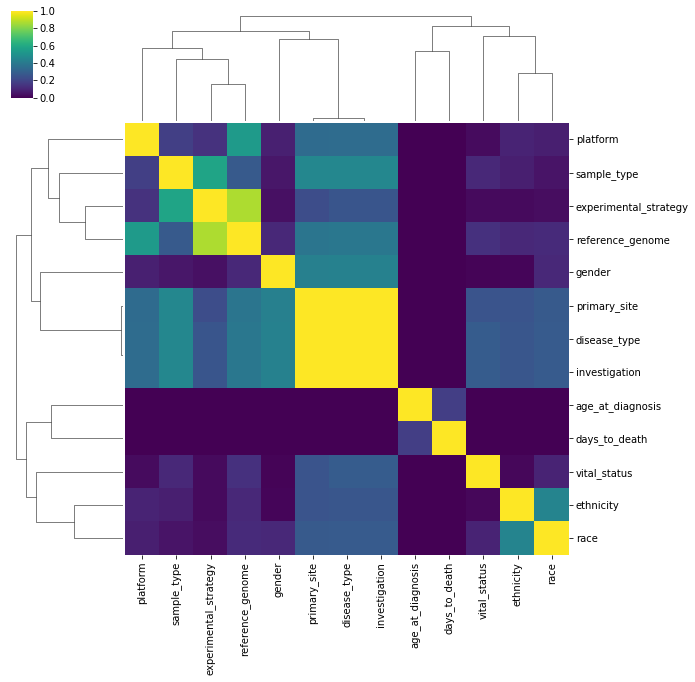

In [8]:
x = correlate_metadata(meta, categorials=fields_categorials, intervals=fields_intervals)

In [11]:
meta.groupby(['primary_site', 'disease_type', 'investigation']).size()

primary_site    disease_type                                                      investigation
Adrenal Gland   Adrenocortical Carcinoma                                          TCGA-ACC           79
Bile Duct       Cholangiocarcinoma                                                TCGA-CHOL          45
Bladder         Bladder Urothelial Carcinoma                                      TCGA-BLCA         729
Blood           Acute Myeloid Leukemia                                            TCGA-LAML         335
Brain           Brain Lower Grade Glioma                                          TCGA-LGG          733
                Glioblastoma Multiforme                                           TCGA-GBM          520
Breast          Breast Invasive Carcinoma                                         TCGA-BRCA        1497
Cervix          Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma  TCGA-CESC         451
Colorectal      Colon Adenocarcinoma                                    

1) 'primary_site', 'disease_type' and 'investigation' are highly correlated. In fact, 'disease_type' has a 1:1 mapping to 'investigation'. There are only "Brain" 2, "Colorectal" 2, "Kidney" 3, "Lung" 2 and "Uterus" 2 'primary_site's with more than one 'disease_type'.

--> We should drop 'primary_site' and 'investigation' and only keep 'disease_type'

In [39]:
fields_categorials = [c for c in fields_categorials if c not in ['primary_site', 'investigation']]

In [3]:
meta.groupby(['experimental_strategy', 'reference_genome']).size()

disease_type                                                      sample_type         
Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma  Blood Derived Normal     70
                                                                  Metastatic                2
                                                                  Primary Tumor           374
                                                                  Solid Tissue Normal       5
Colon Adenocarcinoma                                              Blood Derived Normal    109
                                                                  Metastatic                1
                                                                  Primary Tumor           837
                                                                  Recurrent Tumor           1
                                                                  Solid Tissue Normal      70
Lung Adenocarcinoma                                               B

2) We see a strong correlation between 'experimental_strategy' and 'reference_genome'. In fact, for "RNA-Seq" we see a dominating preference to "HG19", while for "WGS" the references "GRCh37-lite" and "HG19_Broad_variant" are prefered.

In [13]:
meta.groupby(['ethnicity', 'race']).size()

ethnicity               race                                     
HISPANIC OR LATINO      AMERICAN INDIAN OR ALASKA NATIVE                 8
                        ASIAN                                            1
                        BLACK OR AFRICAN AMERICAN                       24
                        NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER        4
                        Not available                                   57
                        WHITE                                          432
NOT HISPANIC OR LATINO  AMERICAN INDIAN OR ALASKA NATIVE                24
                        ASIAN                                          973
                        BLACK OR AFRICAN AMERICAN                     1158
                        NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       22
                        Not available                                   43
                        WHITE                                        10770
Not available           AMERICAN I

3) I don't fully understand the difference between 'ethnicity' and 'race', but we see that it is basically a binary variable telling us if a sample stems from a "Hispanic or Latino" ethnicity or not. However, for most samples this is either not true or the data are not available.

--> we should drop 'ethnicity'

In [40]:
fields_categorials = [c for c in fields_categorials if c not in ['ethnicity']]

### Redundancy Analysis

In [49]:
counts = biom2pandas('/projects/tcga-data/biom_tables_kraken_unfiltered/all/bacteria/Bacterial_all_cancer_types.biom')
alphas = alpha_diversity(counts, rarefaction_depth=None, metrics=['shannon', 'observed_otus'], dry=False, wait=False)
# %time beta_braycurtis = DistanceMatrix.read('/projects/tcga-data/biom_tables_kraken_unfiltered/all/bacteria/beta_diversity_all_cancer_types/bray_curtis_Bacterial_all_cancer_types.txt')
# use precomputed PCoA instead of starting from beta diversity matrix
%time beta_pcoa_braycurtis = OrdinationResults.read('/projects/tcga-data/biom_tables_kraken_unfiltered/all/bacteria/beta_diversity_all_cancer_types/pcoa_bray_curtis_Bacterial_all_cancer_types.txt')

found matching working dir "/home/sjanssen/TMP/ana_adiv_vvs4e_py"
 Was removed.


#### Alpha

found matching working dir "/home/sjanssen/TMP/ana_fRDAalpha_wugfomsu"
 Was removed.


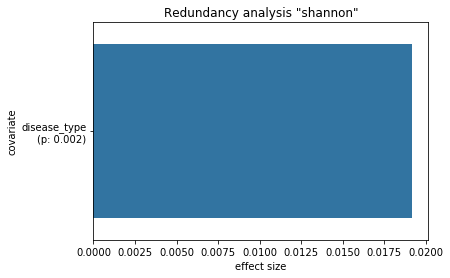

In [55]:
rda_alpha_shannon = redundancy_analysis_alpha(meta, alphas['results']['shannon'], categorials=fields_categorials, intervals=fields_intervals, dry=False, wait=False)

found matching working dir "/home/sjanssen/TMP/ana_fRDAalpha_kjh_cubl"
 Was removed.


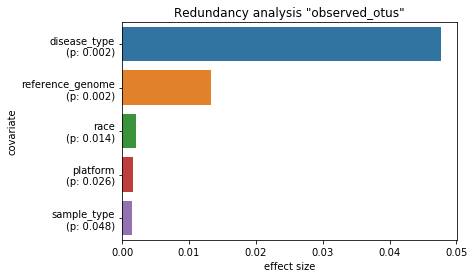

In [57]:
rda_alpha_observed_otus = redundancy_analysis_alpha(meta, alphas['results']['observed_otus'], categorials=fields_categorials, intervals=fields_intervals, dry=False, wait=False)

#### Beta

found matching working dir "/home/sjanssen/TMP/ana_fRDAbeta_yfvevqz4"
 Was removed.


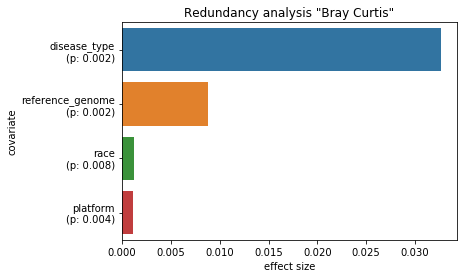

In [93]:
rda_beta_bray_curtis = redundancy_analysis_beta(meta, beta_pcoa_braycurtis, 'Bray Curtis', categorials=fields_categorials, intervals=fields_intervals, dry=False, wait=False)

### Exploration

In [4]:
meta_biol

,age_at_diagnosis,days_to_death,disease_type,ethnicity,gender,race,sample_type,vital_status,primary_site
#SampleID,,,,,,,,,
s0,42.0,NaN,Breast Invasive Carcinoma,Not available,FEMALE,Not available,Blood Derived Normal,Alive,Breast
s1,50.0,1083.0,Cervical Squamous Cell Carcinoma and Endocervi...,NOT HISPANIC OR LATINO,FEMALE,WHITE,Primary Tumor,Dead,Cervix
s2,71.0,31.0,Acute Myeloid Leukemia,NOT HISPANIC OR LATINO,FEMALE,WHITE,Solid Tissue Normal,Dead,Blood
s3,57.0,NaN,Breast Invasive Carcinoma,NOT HISPANIC OR LATINO,FEMALE,WHITE,Solid Tissue Normal,Alive,Breast
s4,60.0,NaN,Esophageal Carcinoma,NOT HISPANIC OR LATINO,MALE,ASIAN,Blood Derived Normal,Alive,Esophagus
s5,61.0,2097.0,Breast Invasive Carcinoma,NOT HISPANIC OR LATINO,FEMALE,BLACK OR AFRICAN AMERICAN,Primary Tumor,Dead,Breast
s6,71.0,NaN,Breast Invasive Carcinoma,NOT HISPANIC OR LATINO,FEMALE,WHITE,Primary Tumor,Alive,Breast
s7,78.0,NaN,Sarcoma,NOT HISPANIC OR LATINO,MALE,WHITE,Blood Derived Normal,Alive,Mesenchymal
s8,67.0,NaN,Esophageal Carcinoma,NOT HISPANIC OR LATINO,FEMALE,ASIAN,Blood Derived Normal,Alive,Esophagus


* Q1: can we predict cancer type by microbiome
* Q2: can we predict status of cancer status by blood vs. primary tumor --> marker

* do we have healthy controls?

In [5]:
meta_biol.loc[['s1340', 's1505'],:]

,age_at_diagnosis,days_to_death,disease_type,ethnicity,gender,race,sample_type,vital_status,primary_site
#SampleID,,,,,,,,,
s1340,62.0,317.0,Glioblastoma Multiforme,NOT HISPANIC OR LATINO,MALE,WHITE,Blood Derived Normal,Dead,Brain
s1505,65.0,NaN,Lung Adenocarcinoma,Not available,FEMALE,Not available,Blood Derived Normal,Alive,Lung
